In [176]:
# import dependencies

import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

In [177]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

In [178]:
def shuffle(X, y):
  """
  Shuffle X and y in the same way
  """
  indices = np.random.permutation(X.shape[0])
  return X[indices], y[indices]

In [179]:
def generate_random_indices(upper_bound, lower_bound=0, size=1):
  """
  Generate random indices between lower_bound and upper_bound
  """
  indices = np.random.choice(
      np.arange(start=lower_bound, stop=upper_bound),
      size=size,
      replace=False
    )
  return indices

## Load Data

In [180]:
X_TRAIN_FILENAME = 'handsignX.npy'
Y_TRAIN_FILENAME = 'handsigny.npy'
X_TEST_FILENAME = 'handsignX_test.npy'
Y_TEST_FILENAME = 'handsigny_test.npy'

In [181]:
# Load train set
X_train = np.load(X_TRAIN_FILENAME)
y_train = np.load(Y_TRAIN_FILENAME)

X_train.shape, y_train.shape

((5000, 400), (5000, 1))

In [182]:
# Load test set
X_test = np.load(X_TEST_FILENAME)
y_test = np.load(Y_TEST_FILENAME)

X_test.shape,y_test.shape

((320, 400), (320, 1))

## Data Visualization

In [183]:
def display_digit(x, y=None):
  """
  Display a 20x20 pixels digit image in grayscale.
  """
  plt.imshow(x.reshape((20, 20)).T, cmap='gray')
  plt.title(f'{y}')

In [184]:
def display_digits_grid(X, y=None, ncols=10, figsize_per_image=(1, 1), cmap='gray'):
    m = X.shape[0]
    nrows = int(np.ceil(m / ncols))

    fig_width = ncols * figsize_per_image[0]
    fig_height = nrows * figsize_per_image[1]

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(fig_width, fig_height),
        constrained_layout=True
      )
    axes = axes.flatten()

    for i in range(m):
        img = X[i].reshape((20, 20)).T
        axes[i].imshow(img, cmap=cmap)
        axes[i].axis('off')
        if y is not None:
            axes[i].set_title(str(y[i]), fontsize=9)

    for i in range(m, len(axes)):
        axes[i].set_visible(False)

    plt.suptitle('Handwritten Digits with Labels')

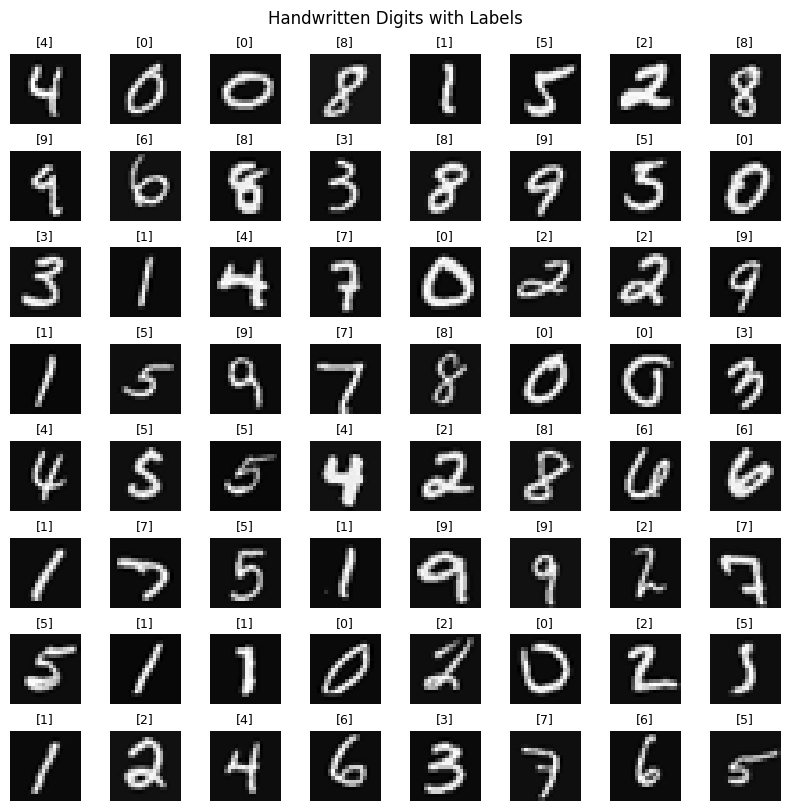

In [185]:
random_indices = generate_random_indices(X_train.shape[0], size=64)
display_digits_grid(X_train[random_indices], y_train[random_indices], ncols=8)

## Data Augmentation

In order to improve generalization to unseen data, it is best that we augment the original dataset such that the augmented dataset produces a wider range of samples to train on.

Elastic distortion slightly stretches and squeezes digit images in random ways, like
changes in natural handwriting. This helps the model learn better by seeing more varied examples.

In [186]:
from scipy.ndimage import map_coordinates, gaussian_filter

def elastic_transform(image, alpha, sigma, random_state=None):
  """
  Elastic deformation of images as described in [Simard2003]_.
  """
  if random_state is None:
    random_state = np.random.RandomState(None)

  shape = image.shape
  # Generate random displacement fields in x and y directions
  dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
  dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

  # Create meshgrid of original pixel coordinates
  x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))

  # Warp the image using the new coordinates
  indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
  # 'reflect' avoids errors at the image edges
  distorted_image = map_coordinates(image, indices, order=1, mode='reflect')

  return distorted_image.reshape(image.shape)

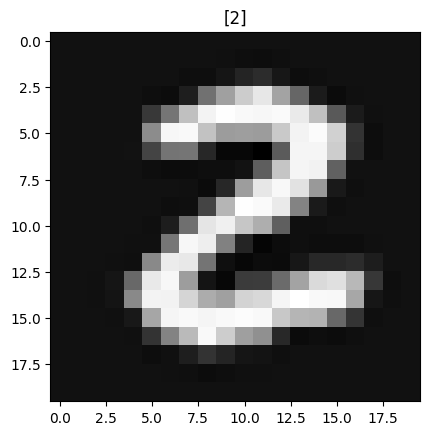

In [187]:
i = 1002
og_img = X_train[i].reshape(20,20)
display_digit(og_img, y_train[i])

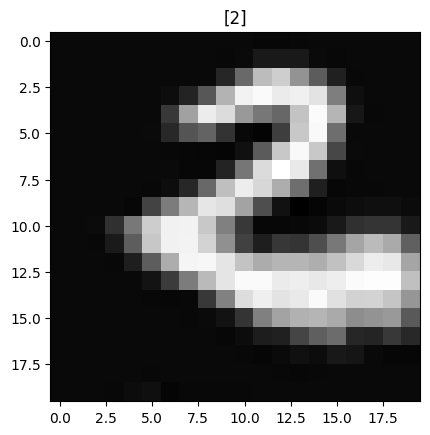

In [188]:
el_img = elastic_transform(og_img.T, alpha=40, sigma=6)
display_digit(el_img.T.reshape(20,20), y_train[i])

Now, we will duplicate the dataset 19 times and apply elastic distortion to each image of the duplicated sets with various alpha and sigma values from u

In [189]:
def duplicate(X, y, indices=None, n=1):
  """
  Duplicate selected samples n times and append to the dataset.
  """
  X_dup = X.copy() if indices is None else X[indices].copy()
  y_dup = y.copy() if indices is None else y[indices].copy()

  X = np.concatenate([X] + [X_dup] * (n-1), axis=0)
  y = np.concatenate([y] + [y_dup] * (n-1), axis=0)

  return X, y

In [190]:
# Produces 19 duplicates of train set
X_dup, y_dup = duplicate(
    X_train, y_train, n=19
  )
X_dup.shape, y_dup.shape

((95000, 400), (95000, 1))

In [191]:
X_dup_size = X_dup.shape[0]

for i in range(X_dup_size):
  original_img = X_dup[i].reshape((20, 20)).T

  # randomly sample alpha and sigma from uniform dist
  alpha = np.random.uniform(30, 45)
  sigma = np.random.uniform(4, 8)
  transformed_img = elastic_transform(original_img, alpha, sigma)

  X_dup[i] = transformed_img.T.ravel()

In [192]:
# Combine the augmented data with the original, and shuffle
X_train_aug = np.concatenate((X_train, X_dup), axis=0)
y_train_aug = np.concatenate((y_train, y_dup), axis=0)

X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)

X_train_aug.shape, y_train_aug.shape

((100000, 400), (100000, 1))

## Feature Scaling

In [193]:
train_mean = X_train_aug.mean(axis=0)
train_std = X_train_aug.std(axis=0)

train_mean.shape, train_std.shape

((400,), (400,))

After trying various scaling techniques, standardization contributed to the best performance.

In [194]:
def standardize(X):
  """
  Apply standardization to X
  """
  # Prevents zero division
  epsilon = 1e-8
  return (X - train_mean) / (train_std + epsilon)

In [195]:
def normalize(X):
  return standardize(X)

In [196]:
X_train_norm = normalize(X_train_aug)
X_test_norm = normalize(X_test / 255.0)

In [197]:
np.save('X_train.npy', X_train_norm)
np.save('y_train.npy', y_train_aug)
np.save('X_test.npy', X_test_norm)
np.save('y_test.npy', y_test)

# Training
We will train a feedforward neural network composed of fully connected hidden layers with ReLU activation functions.

Instead of using the dataset we processed earlier, we will load a different dataset that has been preprocessed in the same way, to reproduce consistent training results.

In [198]:
tf.random.set_seed(42)

In [199]:
# Load preprocessed data to reproduce results
X_train_final = np.load('X_train.npy')
y_train_final = np.load('y_train.npy')
X_test_final = np.load('X_test.npy')
y_test_final = np.load('y_test.npy')

In [200]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Prevents overfitting by stopping training when loss stops improving.
early_stopper = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-5,
    patience=5,
    restore_best_weights=True,
  )

model = Sequential([
    tf.keras.Input(shape=(400,)),
    Dense(256, activation='relu', kernel_regularizer=l2(5e-3)),
    Dense(64, activation='relu', kernel_regularizer=l2(5e-3)),
    Dense(10, activation='linear'),
])

model.compile(
    # used for multi-class classification when labels are integers
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # automatically adjusts the learning rate for each parameter,
    # speeding up convergence.
    optimizer=Adam(learning_rate=3e-4),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_test_final, y_test_final),
    batch_size=64,
    epochs=30,
    callbacks=[early_stopper]
)

Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 2.6984 - sparse_categorical_accuracy: 0.6289 - val_loss: 1.3646 - val_sparse_categorical_accuracy: 0.7531
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.9893 - sparse_categorical_accuracy: 0.8636 - val_loss: 0.9876 - val_sparse_categorical_accuracy: 0.7937
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6916 - sparse_categorical_accuracy: 0.8924 - val_loss: 0.8769 - val_sparse_categorical_accuracy: 0.7906
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5946 - sparse_categorical_accuracy: 0.9045 - val_loss: 0.8172 - val_sparse_categorical_accuracy: 0.7875
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.5470 - sparse_categorical_accuracy: 0.9108 - val_loss: 0.7695 - val_sparse_categorical_accuracy: 0.8062
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5163 - sparse_categorical_accuracy: 0.9149 - val_loss: 0.7411 - val_sparse_categorical_accura

In [220]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │       102,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 359,264 (1.37 MB)

 Trainable params: 119,754 (467.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 239,510 (935.59 KB)

Text(0.5, 1.0, 'Training Accuracy vs No. of Epochs')

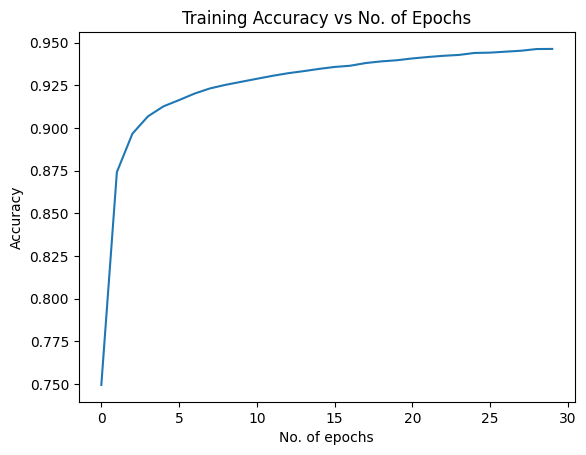

In [221]:
accuracy = history.history['sparse_categorical_accuracy']
n_epochs = range(len(accuracy))

plt.plot(n_epochs, accuracy, label='Training Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs No. of Epochs')

In [222]:
# Generate predictions on test data, convert logits to probabilities,
# compute predicted classes, and calculate test accuracy
logits = model.predict(X_test_final)
probs = tf.nn.softmax(logits).numpy()
y_pred = np.argmax(probs, axis=1).reshape(-1, 1)

test_accuracy = (y_pred == y_test_final).sum() / y_test.shape[0] * 100
print(f"Test accuracy: {test_accuracy:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test accuracy: 85.00%


In [223]:
def get_bins(X, y):
  """
  """
  unique_values = np.unique(y)
  Xbins = []
  ybins = []

  for val in unique_values:
    indices = np.where(y == val)[0]
    Xbins.append(X[indices])
    ybins.append(y[indices])

  return np.array(Xbins), np.array(ybins)

In [225]:
Xbins, ybins = get_bins(X_test_final, y_test_final)

Xbins.shape, ybins.shape

((10, 32, 400), (10, 32, 1))

In [226]:
# Get accuracy for each digit in the test set
for i in range(ybins.shape[0]):
  accuracy = model.evaluate(Xbins[i], ybins[i])
  print(f"Class {i} accuracy: {accuracy[1] * 100}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1656 - sparse_categorical_accuracy: 1.0000
Class 0 accuracy: 100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1772 - sparse_categorical_accuracy: 1.0000
Class 1 accuracy: 100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.3372 - sparse_categorical_accuracy: 0.9062
Class 2 accuracy: 90.625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6519 - sparse_categorical_accuracy: 0.7812
Class 3 accuracy: 78.125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6052 - sparse_categorical_accuracy: 0.8438
Class 4 accuracy: 84.375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5417 - sparse_categorical_accuracy: 0.9062
Class 5 accuracy: 90.625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4641 - sparse_categorical_accuracy: 0.8750
Class 6 accuracy: 87.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6489 - sparse_categorical_accuracy: 0.8125
Class 7 accuracy: 81.25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.9351 - sparse_categorical_acc

# Inference of One Instance

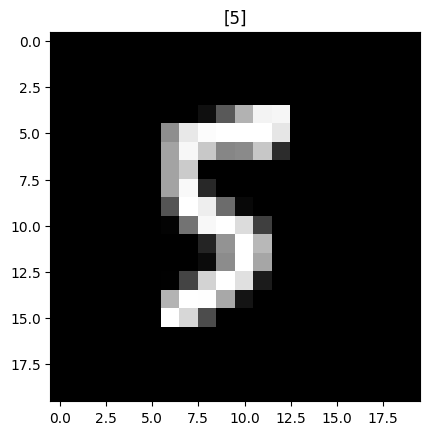

In [207]:
i = 91
display_digit(X_test[i], y_pred[i])

# Saving Model

In [208]:
model.save("DigiNet.keras")

# Test Set Generation

We have generated the test set by using transforming our handwriting to match the MNIST digit images as closely as we could in order to minimize domain shift.

In [209]:
import cv2

img1 = cv2.imread("hw_digits_1.jpg", flags=cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("hw_digits_2.jpg", flags=cv2.IMREAD_GRAYSCALE)

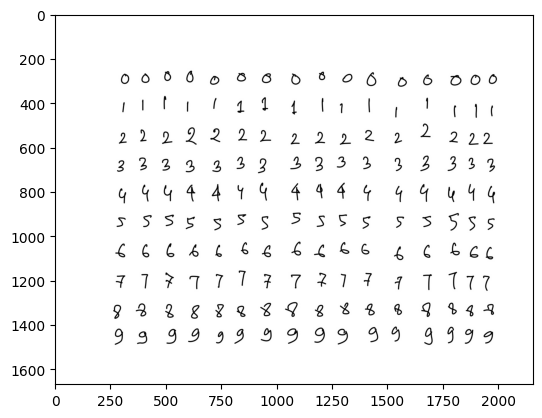

In [210]:
plt.imshow(img1, cmap="gray")

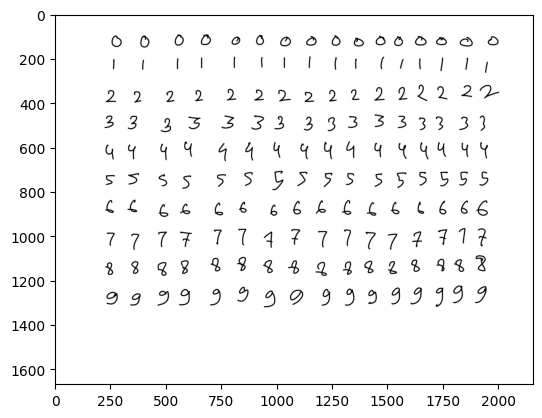

In [211]:
plt.imshow(img2, cmap="gray")

In [212]:
def resize_and_pad(image, size=20, pad_value=0):
    """
    Resize image to fit within target size while maintaining aspect ratio,
    then pad to exact target size
    """
    h, w = image.shape

    # Calculate scale to fit into target size with some margin
    margin = 4
    target_inner = size - 2 * margin

    if h > w:
        new_h = target_inner
        new_w = int(w * (new_h / h))
    else:
        new_w = target_inner
        new_h = int(h * (new_w / w))

    # Ensure minimum size
    new_h = max(new_h, 1)
    new_w = max(new_w, 1)

    # Resize image
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Calculate padding
    top = (size - new_h) // 2
    bottom = size - new_h - top
    left = (size - new_w) // 2
    right = size - new_w - left

    # Apply padding
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                borderType=cv2.BORDER_CONSTANT, value=pad_value)

    return padded

In [213]:
import cv2
import numpy as np

def get_digit_arrays(img, target_size=20):
    """
    Extract and preprocess handwritten digits to MNIST-like format,
    with thickness enhancement using dilation.
    """
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(img, (3, 3), 0)

    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2
    )

    # Make digits thicker using dilation
    kernel = np.ones((4, 4), np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations=1)

    # Find contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours by area
    min_area = 50
    max_area = 5000
    valid_contours = [c for c in contours if min_area < cv2.contourArea(c) < max_area]

    # Bounding boxes
    bounding_boxes = [cv2.boundingRect(c) for c in valid_contours]

    # Sort contours (top-to-bottom, left-to-right)
    def get_row_col(box):
        x, y, w, h = box
        row = y // (target_size + 10)
        return (row, x)

    sorted_boxes = sorted(bounding_boxes, key=get_row_col)

    digit_images = []
    for x, y, w, h in sorted_boxes:
        digit = dilated[y:y+h, x:x+w]
        processed_digit = resize_and_pad(digit, size=target_size, pad_value=0)
        digit_images.append(processed_digit)

    X = np.array(digit_images).reshape((len(digit_images), target_size * target_size))
    return X


In [214]:
X1 = get_digit_arrays(img1)
X2 = get_digit_arrays(img2)

X1.shape, X2.shape

((160, 400), (160, 400))

In [215]:
# Generate labels
y1 = np.repeat(np.arange(10), 16).reshape((160, 1))
y2 = np.repeat(np.arange(10), 16).reshape((160, 1))

y1.shape, y2.shape

((160, 1), (160, 1))

In [216]:
# Reshape digit arrays by switching x and y dimensions
n_images_1 = X1.shape[0]
n_images_2 = X2.shape[0]

X1 = X1.reshape(n_images_1, 20, 20).transpose(0, 2, 1).reshape(n_images_1, 400)
X2 = X2.reshape(n_images_2, 20, 20).transpose(0, 2, 1).reshape(n_images_2, 400)

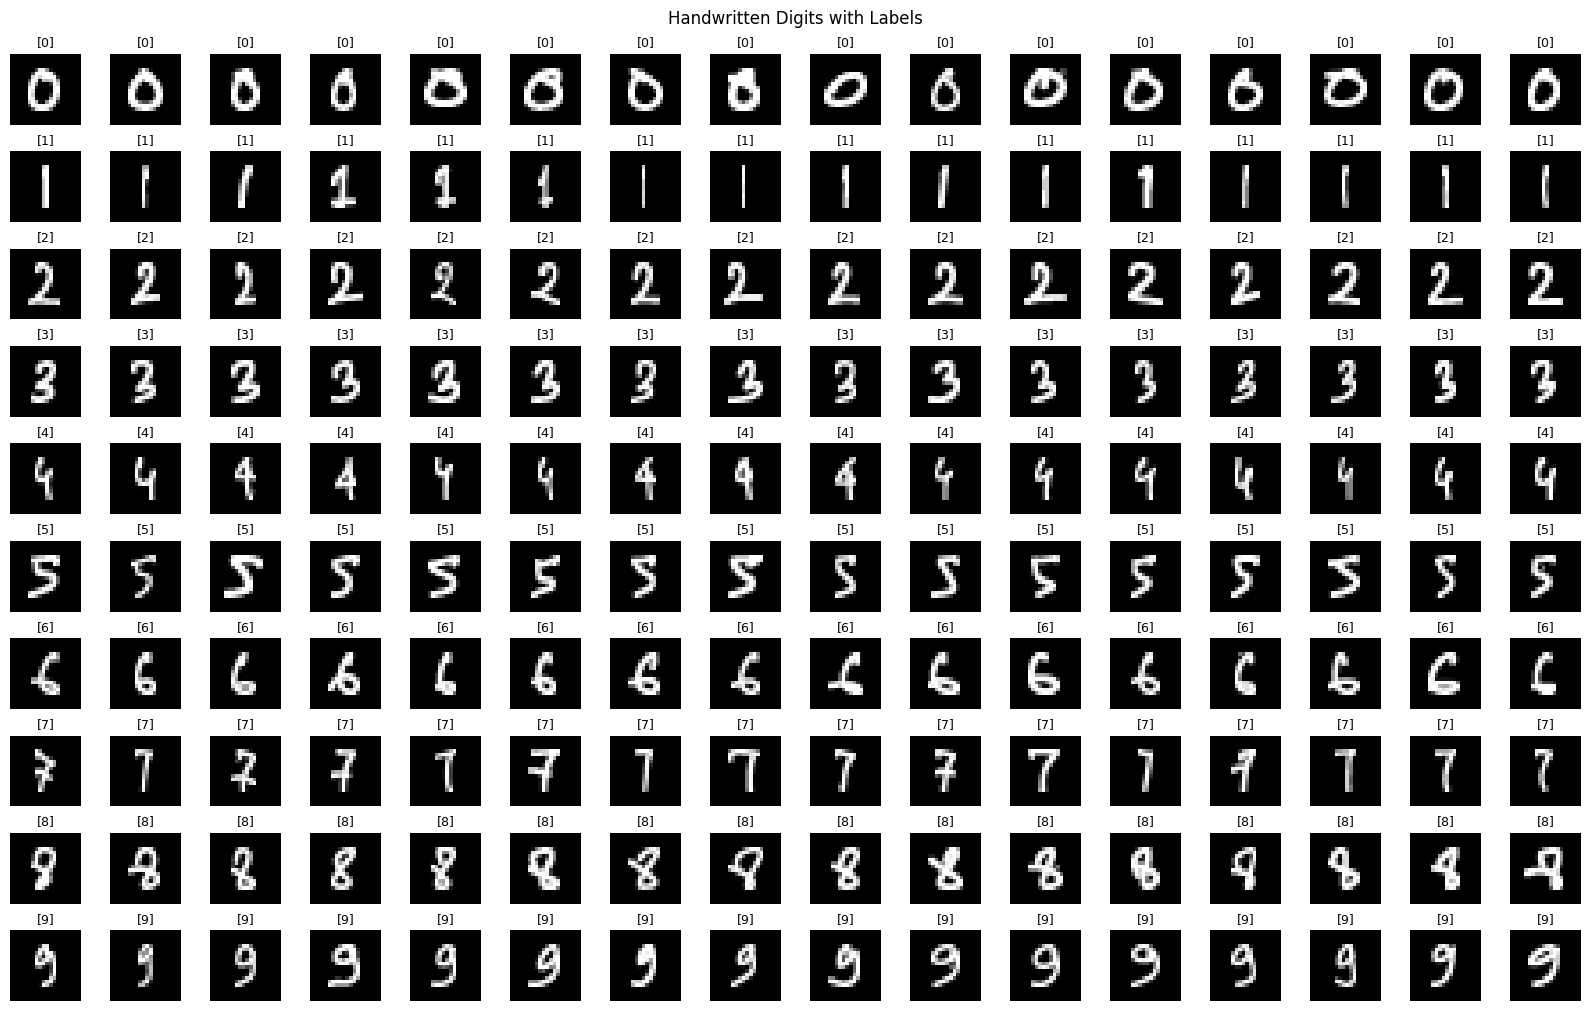

In [217]:
display_digits_grid(X1, y1, ncols=16)

In [218]:
X = np.concatenate((X1, X2), axis=0)
y = np.concatenate((y1, y2), axis=0)

X.shape, y.shape

((320, 400), (320, 1))

In [219]:
np.save("handsignX_test.npy", X)
np.save("handsigny_test.npy", y)